# Chapter 13: Loading and Preprocessing Data with TensorFlow

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from pathlib import Path
from functools import partial
from time import strftime
import numpy as np
import pandas as pd
from collections import Counter
import re
import matplotlib.pyplot as plt

1. The `tf.data` API is useful for reading in data gradually from your hard drive and preprocessing data, it revolves around `tf.data.Dataset` which represents a sequence of data items.

2. Splitting the data across multiple files can help with shuffling the data, `tf.data.Dataset.list_files()` automatically shuffles the file paths and the `.interleave()` method with argument `cycle_length > 1` will read from multiple files simultaneously. It can also improve performance, setting `num_parallel_calls=tf.data.AUTOTUNE` TensorFlow will choose the right number of threads dynamically based on the available CPU.

3. During training if your GPU utilization is very low, the input pipeline might be the bottleneck. You should call `.prefetch()` so that the dataset has a set number of batches ready to go in memory, or if the whole dataset can fit in memory, call `.cache()` after loading and preprocessing the data, but before shuffling, repeating, batching, and prefetching. Other approaches:
    * read and preprocess the data with multiple threads in parallel,
    * make sure your preprocessing code is optimized,
    * save the dataset into multiple TFRecord files,
    * if necessary perform some of the preprocessing ahead of time so that it does not need to be done on the fly during training (TF Transform can help with this), &
    * if necessary, use a machine with more CPU and RAM, and ensure that the GPU bandwidth is large enough.

4. You can save any binary data to a TFRecord file, however in practice *protobufs* are used.

5. The `Example` protobuf format has the advantage that TensorFlow provides some operations to parse it (the `tf.io.parse`*`example()` functions) without you having to define your own format. It is sufficiently flexible to represent instances in most datasets.

6. Compressing TFRecord files is useful if they need to be loaded via a network connection, e.g. from AWS S3. However, you shouldn't do this if you don't need to as decompressing the files could slow down training.

7. Data preprocessing can take place in three ways:
    1. when writing the data files
        * **pros:** this will speed up training, the training data may also take up less space e.g. you apply dimensionality reduction
        * **cons:** however you must make sure you apply the same preprocessing steps in production, its also not easy to try out different preprocessing steps, also not good for data augmentation
    2. within the `tf.data` pipeline
        * **pros:** its much easier to experiment with preprocessing steps & data augmentation, multithreading and prefetching can make it very efficient, you can use preprocessing layers in your `tf.data` pipeline and then reuse these layers when deploying your model to production
        * **cons:** it will still slow down training, each instance will be preprocessed once per epoch (unless you can use `.cache`), must remember to apply the same preprocessing steps in production
    3. preprocessing layers of your model
        * **pros:** this is good for inference, as your model will be able to handle raw data, you will not run the risk of mismatch between your training preprocessing & inference preprocessing
        * **cons:** it will slow down training, with each instance being processed multiple times

8. Categorical features can be encoded using integers if there is a natural ordering or one-hot encoding. For text, where each token is a category, you have far too many categories to use one-hot so embeddings make much more sense.

## 9. Fashion MNIST data pipeline

9.a. Writing the data.

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
class_labels = (
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
)


train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(
    buffer_size=60_000
)
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

valid_size = 2048

valid_set = train_set.take(valid_size)
train_set = train_set.skip(valid_size)


def serialize(image, label):
    image_data = tf.io.serialize_tensor(image)
    protobuf_example = tf.train.Example(
        features=tf.train.Features(
            feature={
                "image": tf.train.Feature(
                    bytes_list=tf.train.BytesList(value=[image_data.numpy()])
                ),
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
            }
        )
    )
    return protobuf_example.SerializeToString()


data_dir = Path("datasets/13/fashion_mnist")
num_shards = 5

datasets = {
    "train_set": train_set,
    "valid_set": valid_set,
    "test_set": test_set,
}

file_paths = dict()
for dataset_name, dataset in datasets.items():

    dataset_dir = data_dir / dataset_name
    dataset_dir.mkdir(parents=True, exist_ok=True)

    file_paths[dataset_name] = [
        str(dataset_dir / f"{dataset_name}-{i}-of-{num_shards}.tfrecord")
        for i in range(1, num_shards + 1)
    ]

    if not any(dataset_dir.iterdir()):
        writers = [
            tf.io.TFRecordWriter(file_path) for file_path in file_paths[dataset_name]
        ]

        for i, (image, label) in dataset.enumerate():
            writers[i % num_shards].write(serialize(image, label))

        for writer in writers:
            writer.close()
    else:
        print(f"Skipping {dataset_name} as directory is not empty.")

del (
    X_test,
    y_test,
    y_train,
    test_set,
    train_set,
    valid_set,
    data_dir,
    dataset,
    dataset_dir,
    dataset_name,
    datasets,
)

Skipping train_set as directory is not empty.
Skipping valid_set as directory is not empty.
Skipping test_set as directory is not empty.


In [3]:
def parse(serialized_example):

    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }

    protobuf_example = tf.io.parse_single_example(
        serialized_example, feature_description
    )

    return (
        tf.io.parse_tensor(protobuf_example["image"], out_type=tf.uint8),
        tf.cast(protobuf_example["label"], tf.uint8),
    )


norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)


def preprocess(X, y):
    return tf.reshape(norm_layer(X), (28, 28, 1)), y


def get_dataset(dataset_name, shuffle=False, sample=None):
    dataset = (
        tf.data.TFRecordDataset(file_paths[dataset_name], num_parallel_reads=num_shards)
        .map(parse, num_parallel_calls=tf.data.AUTOTUNE)
        .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
    )

    if shuffle:
        dataset = dataset.shuffle(60_000 - valid_size)

    if sample:
        dataset = dataset.take(sample)

    return dataset.batch(32).prefetch(tf.data.AUTOTUNE)


train_dataset = get_dataset("train_set", shuffle=True, sample=4096)
valid_dataset = get_dataset("valid_set")
test_dataset = get_dataset("test_set")

In [4]:
DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=3,
    padding="same",
    activation="relu",
    kernel_initializer="he_normal",
)

model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(28, 28, 1)),
        DefaultConv2D(filters=64, kernel_size=7),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=128),
        DefaultConv2D(filters=128),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=128, activation="relu", kernel_initializer="he_normal"
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(
            units=64, activation="relu", kernel_initializer="he_normal"
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=10, activation="softmax"),
    ]
)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"]
)

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=valid_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=5, restore_best_weights=True, verbose=1
        ),
        tf.keras.callbacks.TensorBoard(
            f"models/TensorBoard/13/{strftime('run_%Y_%m_%d_%H_%M_%S')}",
            profile_batch="20,120",
        ),
    ],
)

Epoch 1/100


2025-02-05 21:11:25.832909: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2025-02-05 21:11:25.832923: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2025-02-05 21:11:25.832953: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


     20/Unknown - 7s 171ms/step - loss: 2.8020 - accuracy: 0.1750

2025-02-05 21:11:32.885238: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2025-02-05 21:11:32.885266: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


    119/Unknown - 24s 167ms/step - loss: 1.8925 - accuracy: 0.3474

2025-02-05 21:11:49.689316: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.


    121/Unknown - 25s 174ms/step - loss: 1.8839 - accuracy: 0.3505

2025-02-05 21:11:50.497727: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2025-02-05 21:11:50.501520: I tensorflow/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: models/TensorBoard/13/run_2025_02_05_21_11_25/plugins/profile/2025_02_05_21_11_50/Edwards-MacBook-Air.local.xplane.pb


128/128 [==============================] - 39s 275ms/step - loss: 1.8577 - accuracy: 0.3569 - val_loss: 1.0060 - val_accuracy: 0.6987
Epoch 2/100
128/128 [==============================] - 32s 254ms/step - loss: 1.1666 - accuracy: 0.5859 - val_loss: 0.6669 - val_accuracy: 0.7613
Epoch 3/100
128/128 [==============================] - 33s 259ms/step - loss: 0.9402 - accuracy: 0.6707 - val_loss: 0.6027 - val_accuracy: 0.7829
Epoch 4/100
128/128 [==============================] - 31s 245ms/step - loss: 0.8095 - accuracy: 0.7148 - val_loss: 0.5038 - val_accuracy: 0.8144
Epoch 5/100
128/128 [==============================] - 32s 248ms/step - loss: 0.7054 - accuracy: 0.7502 - val_loss: 0.4859 - val_accuracy: 0.8356
Epoch 6/100
128/128 [==============================] - 32s 251ms/step - loss: 0.6923 - accuracy: 0.7656 - val_loss: 0.4559 - val_accuracy: 0.8382
Epoch 7/100
128/128 [==============================] - 32s 253ms/step - loss: 0.6075 - accuracy: 0.7861 - val_loss: 0.4313 - val_accurac

## 10. Binary classification of the [Large Movie Review Dataset](https://homl.info/imdb)

Creating a function that parses a single file.

In [5]:
data_dir = Path("datasets/13/aclImdb")


def parse(file_path):
    content = tf.io.read_file(file_path)

    label = tf.strings.regex_replace(file_path, ".*/(pos|neg)/.*", "\\1")
    label = tf.cast(tf.equal(label, "pos"), tf.int32)

    return content, label

Doing some basic analysis of the text data.

In [6]:
train_text = (
    tf.data.Dataset.list_files(
        [str(data_dir / f"train/{class_}/*") for class_ in ["pos", "neg"]]
    )
    .map(lambda file_path: parse(file_path)[0], num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

It makes sense to set `output_sequence_length=512` in the `TextVectorization` preprocessing layer since many reviews are shorter than this.

In [7]:
lengths = []

for text_batch in train_text:
    for text in text_batch:
        num_words = len(str(text.numpy()).split())
        lengths.append(num_words)

pd.Series(lengths).describe(percentiles=[0.5, 0.9])

count    25000.000000
mean       233.776720
std        173.715418
min         10.000000
50%        174.000000
90%        458.000000
max       2470.000000
dtype: float64

Determining a good vocabulary size (only the most frequent `max_tokens` will be kept)

In [8]:
text_vec_layer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation"
)
text_vec_layer.adapt(train_text)

vocab_size = len(text_vec_layer.get_vocabulary())
vocab_size

121894

In [9]:
token_counts = Counter()

for text_batch in train_text:
    for text in text_batch:
        standardized_text = re.sub(r"[^\w\s]", "", text.numpy().decode("utf-8").lower())
        tokens = str(standardized_text).split()
        token_counts.update(tokens)

token_counts_df = pd.DataFrame(
    list(token_counts.items()), columns=["token", "count"]
).sort_values(by="count", ascending=False, ignore_index=True)

At least half of the tokens only appear once in the training text and 90% of the tokens appear $\leq$ 23 times, which makes training an embedding for them difficult, therefore it makes sense to clip the vocab to 10,000 of the most frequent tokens out of the ~120,000 total token size.

i.e. setting `max_tokens=10_000` in my `TextVectorization` layer.

In [10]:
token_counts_df["count"].describe(percentiles=[0.5, 0.9])

count    121045.000000
mean         48.083919
std        1539.305968
min           1.000000
50%           1.000000
90%          23.000000
max      334706.000000
Name: count, dtype: float64

In [11]:
text_vec_layer = tf.keras.layers.TextVectorization(
    output_sequence_length=512,
    max_tokens=10_000,
    standardize="lower_and_strip_punctuation",
)


text_vec_layer.adapt(train_text)

Creating train, test, & validation datasets.

In [12]:
def get_movie_dataset(train=False):
    file_paths = [
        str(data_dir / f"{'train' if train else 'test'}/{class_}/*")
        for class_ in ["pos", "neg"]
    ]
    return (
        tf.data.Dataset.list_files(file_paths, shuffle=True)
        .map(parse, num_parallel_calls=tf.data.AUTOTUNE)
        .map(
            lambda text, label: (text_vec_layer(text), label),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        .cache()
        .shuffle(25_000)
    )


train_dataset = get_movie_dataset(train=True).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = get_movie_dataset()
valid_dataset = test_dataset.take(15_000).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.skip(15_000).batch(32).prefetch(tf.data.AUTOTUNE)

In [13]:
next(iter(train_dataset))

(<tf.Tensor: shape=(32, 512), dtype=int64, numpy=
 array([[  85,  111,  773, ...,    0,    0,    0],
        [  10,  208,   11, ...,    0,    0,    0],
        [ 450,  877,    2, ...,    0,    0,    0],
        ...,
        [ 132,    7,    2, ...,    0,    0,    0],
        [  10,  208,   11, ...,    0,    0,    0],
        [3726,   84,  112, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 0], dtype=int32)>)

Creating a model with an `Embedding` layer & then makes predictions based on the mean embedding of the review.

In [14]:
tf.keras.backend.clear_session()


def make_text_model():
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Input(shape=(512)),
            tf.keras.layers.Embedding(
                input_dim=text_vec_layer.vocabulary_size(),
                output_dim=500,
                mask_zero=True,
            ),
            tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1)),
        ]
    )

    for _ in range(5):
        model.add(
            tf.keras.layers.Dense(
                100, activation="relu", kernel_initializer="he_normal"
            )
        )

    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])

    return model


model = make_text_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 500)          5000000   
                                                                 
 lambda (Lambda)             (None, 500)               0         
                                                                 
 dense (Dense)               (None, 100)               50100     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               1

In [15]:
class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, starting_lr, end_lr, n_iter):
        self.factor = (end_lr / starting_lr) ** (1 / n_iter)
        self.starting_lr = starting_lr
        self.end_lr = end_lr
        self.learning_rates = []
        self.losses = []

    def on_train_begin(self, logs=None):
        self.model.optimizer.learning_rate = self.starting_lr

    def on_train_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy() * self.factor
        if lr > self.end_lr:
            print(
                "\nReached end learning rate, stopping training",
                f"Learning rate of minimum loss: {self.learning_rates[np.argmin(self.losses)]}",
                sep="\n",
            )
            self.model.stop_training = True

        self.model.optimizer.learning_rate = lr
        self.learning_rates.append(lr)
        self.losses.append(logs["loss"])


model = make_text_model()
exponential__learning_rate_cb = ExponentialLearningRate(1e-4, 1e-1, 2000)

history = model.fit(
    train_dataset,
    epochs=100,
    callbacks=[exponential__learning_rate_cb],
    verbose=0,
)


Reached end learning rate, stopping training
Learning rate of minimum loss: 0.0015794261715328444


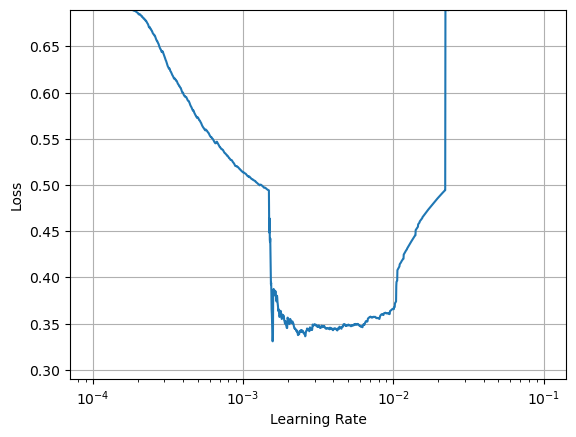

In [16]:
fig, ax = plt.subplots()

ax.plot(
    exponential__learning_rate_cb.learning_rates,
    exponential__learning_rate_cb.losses,
)
ax.set_xscale("log")
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Loss")
ax.set_ylim(0.29, 0.69)
ax.grid(True)

In [17]:
model = make_text_model()
model.optimizer.learning_rate = 1.5e-3 / 2

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=valid_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=5, restore_best_weights=True, verbose=1
        ),
        tf.keras.callbacks.TensorBoard(
            f"models/TensorBoard/13/{strftime('run_%Y_%m_%d_%H_%M_%S')}",
            profile_batch="650,700",
        ),
    ],
)

Epoch 1/100


2025-02-05 21:25:24.741083: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2025-02-05 21:25:24.741100: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2025-02-05 21:25:24.741118: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


655/782 [========================>.....] - ETA: 3s - loss: 0.4245 - accuracy: 0.7863

2025-02-05 21:25:41.988748: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2025-02-05 21:25:41.988767: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


706/782 [==========================>...] - ETA: 2s - loss: 0.4174 - accuracy: 0.7916

2025-02-05 21:25:45.485244: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2025-02-05 21:25:45.510042: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2025-02-05 21:25:45.510435: I tensorflow/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: models/TensorBoard/13/run_2025_02_05_21_25_24/plugins/profile/2025_02_05_21_25_45/Edwards-MacBook-Air.local.xplane.pb


782/782 [==============================] - 27s 33ms/step - loss: 0.4055 - accuracy: 0.7996 - val_loss: 0.3555 - val_accuracy: 0.8383
Epoch 2/100
782/782 [==============================] - 21s 26ms/step - loss: 0.2377 - accuracy: 0.9048 - val_loss: 0.2855 - val_accuracy: 0.8846
Epoch 3/100
782/782 [==============================] - 21s 26ms/step - loss: 0.1878 - accuracy: 0.9258 - val_loss: 0.3434 - val_accuracy: 0.8501
Epoch 4/100
782/782 [==============================] - 21s 26ms/step - loss: 0.1492 - accuracy: 0.9426 - val_loss: 0.3915 - val_accuracy: 0.8566
Epoch 5/100
782/782 [==============================] - 21s 27ms/step - loss: 0.1151 - accuracy: 0.9547 - val_loss: 0.5139 - val_accuracy: 0.8556
Epoch 6/100
782/782 [==============================] - 21s 27ms/step - loss: 0.0919 - accuracy: 0.9639 - val_loss: 0.4586 - val_accuracy: 0.8671
Epoch 7/100
782/782 [==============================] - 21s 27ms/step - loss: 0.0762 - accuracy: 0.9694 - val_loss: 0.5357 - val_accuracy: 0.85

In [20]:
datasets = tfds.load(name="imdb_reviews")
train_set, test_set = datasets["train"], datasets["test"]
for example in train_set.take(1):
    print(example["text"])
    print(example["label"])

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


2025-02-05 23:01:05.009189: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
